In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# 8GB RAM

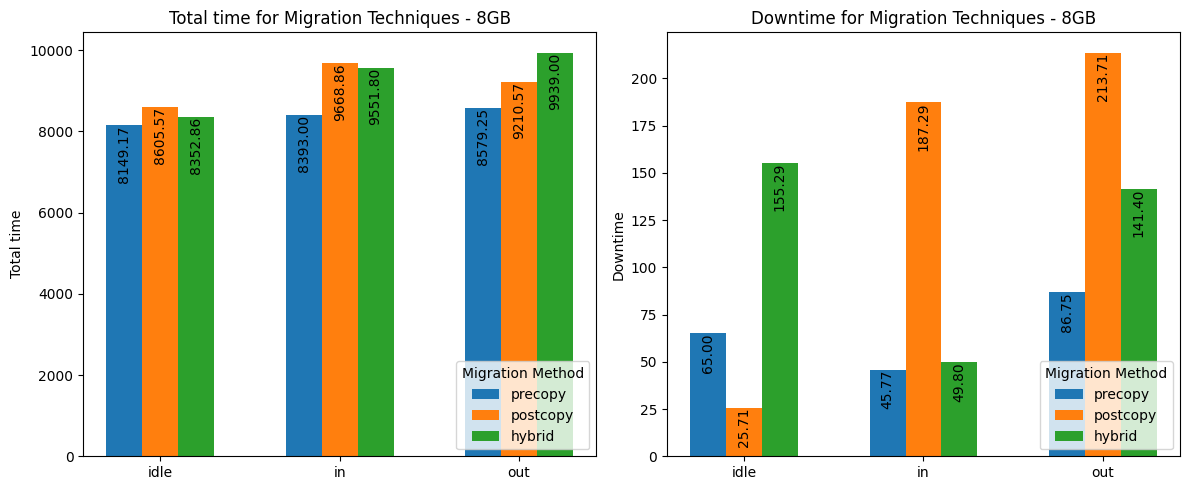

In [2]:

def get_latest_folder(path):
    """Get the last folder alphabetically sorted inside the given path."""
    folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    return os.path.join(path, sorted(folders)[-1]) if folders else None

def extract_migration_data(folder):
    """Extract total-time and downtime values from JSON log files inside the folder."""
    total_times = []
    downtimes = []
    
    for file in os.listdir(folder):
        if file.endswith(".log") or file.endswith(".json"):
            filepath = os.path.join(folder, file)
            with open(filepath, 'r') as f:
                for line in f:
                    try:
                        data = json.loads(line)
                        if "return" in data and "total-time" in data["return"]:
                            total_times.append(data["return"]["total-time"])
                            downtimes.append(data["return"]["downtime"])
                    except json.JSONDecodeError:
                        continue
    
    return np.mean(total_times) if total_times else 0, np.mean(downtimes) if downtimes else 0

def process_migration_data(base_path):
    """Process all folders and extract required values."""
    results = {"idle": {}, "in": {}, "out": {}}
    
    for traffic in ["idle", "in", "out"]:
        for method in ["precopy", "postcopy", "hybrid"]:
            folder_path = os.path.join(base_path, traffic, method)
            latest_folder = get_latest_folder(folder_path)
            
            if latest_folder:
                total_time, downtime = extract_migration_data(latest_folder)
                results[traffic][method] = {"total-time": total_time, "downtime": downtime}
    
    return results

def plot_migration_data(results, ram):
    """Plot migration data as bar charts with values printed on top of the bars, grouped by traffic type."""
    methods = ["precopy", "postcopy", "hybrid"]
    traffic_types = ["idle", "in", "out"]
    x_labels = np.arange(len(traffic_types))
    
    # Define the bar width for each group
    bar_width = 0.2
    
    # Define colors for the three migration methods
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green for 'precopy', 'postcopy', 'hybrid'
    
    # Set up the figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    for idx, metric in enumerate(["total-time", "downtime"]):
        # Get values for each traffic type
        values = {
            traffic: [results[traffic].get(m, {}).get(metric, 0) for m in methods] 
            for traffic in traffic_types
        }
        
        # Plot the bars for each migration method (side by side for each traffic type)
        for i, traffic in enumerate(traffic_types):
            for j, method in enumerate(methods):
                # Adjust x position for each method, so they don't overlap
                axs[idx].bar(x_labels[i] + j * bar_width - bar_width, 
                             values[traffic][j], 
                             width=bar_width, 
                             label=method if i == 0 else "",  # Label only for the first set of bars (for legend)
                             color=colors[j])  # Set color for each migration method
        
        # Adding the values on top of the bars with 90-degree rotation
        for i, traffic in enumerate(traffic_types):
            for j, method in enumerate(methods):
                bar = axs[idx].containers[i * len(methods) + j]  # Get the correct bar container
                for b in bar:
                    yval = b.get_height()
                    axs[idx].text(b.get_x() + b.get_width() / 2, yval + 0.1, f'{yval:.2f}', 
                                  ha='center', va='top', rotation=90)
        
        # Set up the x-ticks, labels, and axis titles
        axs[idx].set_xticks(x_labels)
        axs[idx].set_xticklabels(traffic_types)
        axs[idx].set_ylabel(metric.replace("-", " ").capitalize())
        axs[idx].set_title(f'{metric.replace("-", " ").capitalize()} for Migration Techniques - {ram}GB')

        # Manually set the legend for the migration techniques
        axs[idx].legend(title="Migration Method", loc="lower right")
    
    plt.tight_layout()
    plt.show()


# Main execution
base_path = "s-idle-d-idle"
results = process_migration_data(base_path)
plot_migration_data(results, 8)

# 2GB RAM

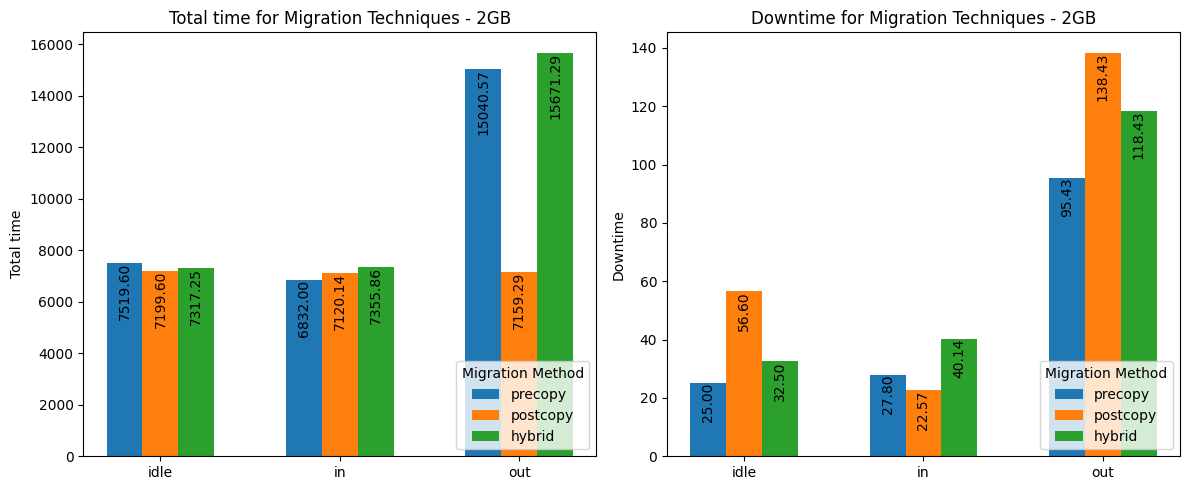

In [3]:
base_path = "RAM-2GB/s-idle-d-idle"
results = process_migration_data(base_path)
plot_migration_data(results, 2)

# 4GB RAM

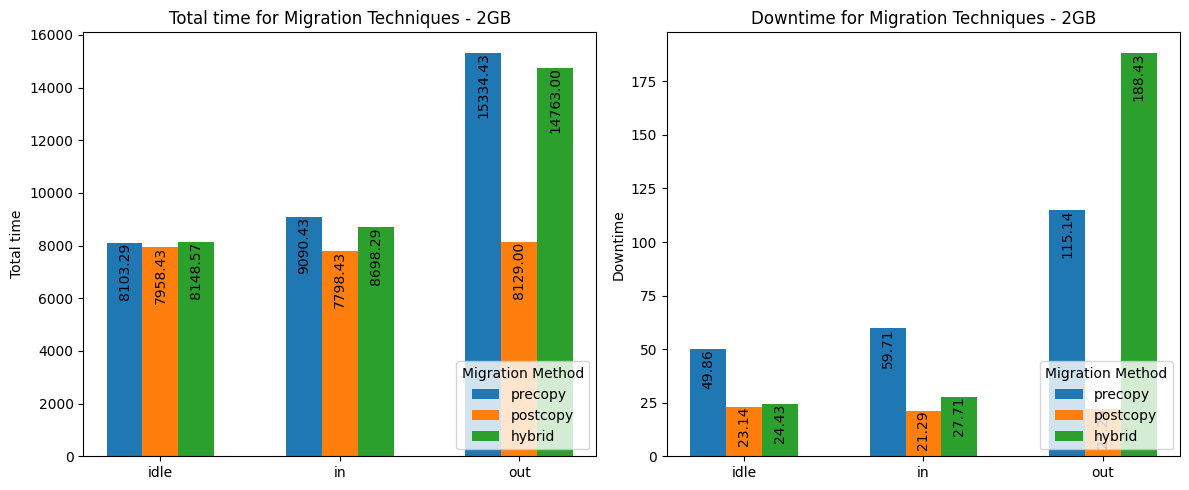

In [4]:
base_path = "RAM-4GB/s-idle-d-idle"
results = process_migration_data(base_path)
plot_migration_data(results, 2)